# Setup Requirements

## Import Libraries

In [1]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

## Specify Paths

In [2]:
m_dataset_path = 'data/m_data.csv'
m_model_save_path = 'model/m_model.keras'
m_tflite_save_path = 'model/m_model.tflite'

## Setup Attributes

In [3]:
# Data Attributes
M_NUM_CLASSES = 3
M_SEQ = 21
REFERENCE_LANDMARKS_NUM = 21
DIMENSION = 2

# Model Attributes
RANDOM_SEED = 42
TRAIN_SIZE = 0.8
TRAIN_SPLIT_SIZE = 0.75
EPOCHS = 150
BATCH_SIZE = 8
EARLY_STOPPING_PATIENCE = 8

# Preprocess Data

## Load Data

In [4]:
X_m_dataset = np.loadtxt(m_dataset_path, delimiter=',', dtype='float32', usecols=list(range(1, (M_SEQ * (REFERENCE_LANDMARKS_NUM * DIMENSION)) + 1)))

In [5]:
y_m_dataset = np.loadtxt(m_dataset_path, delimiter=',', dtype='int32', usecols=(0))

## Split Train/Test

In [6]:
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_m_dataset, y_m_dataset, train_size=TRAIN_SIZE, random_state=RANDOM_SEED)
X_m_train, X_m_val, y_m_train, y_m_val = train_test_split(X_m_train, y_m_train, train_size=TRAIN_SPLIT_SIZE, random_state=RANDOM_SEED)

# Build Model

## Construct Model

In [7]:
m_model = tf.keras.models.Sequential([
    tf.keras.layers.Input((M_SEQ * (REFERENCE_LANDMARKS_NUM * DIMENSION),)),
    tf.keras.layers.Reshape((M_SEQ, (REFERENCE_LANDMARKS_NUM * DIMENSION)), input_shape=(M_SEQ * (REFERENCE_LANDMARKS_NUM * DIMENSION), )),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, input_shape=[(M_SEQ, (REFERENCE_LANDMARKS_NUM * DIMENSION))], activation='tanh')),
    #tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(M_NUM_CLASSES, activation='softmax')
])

## Compile Model

In [8]:
# Model compilation
m_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Setup Callbacks

In [9]:
# Model checkpoint callback
m_cp_callback = tf.keras.callbacks.ModelCheckpoint(
    m_model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, verbose=1)

## Summary

In [10]:
m_model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 21, 42)            0         
                                                                 
 bidirectional (Bidirection  (None, 128)               54784     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

# Train Model

In [11]:
m_model.fit(
    X_m_train,
    y_m_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_m_val, y_m_val),
    callbacks=[m_cp_callback, es_callback]
)

Epoch 1/150


743/750 [============================>.] - ETA: 0s - loss: 0.2922 - accuracy: 0.8928
Epoch 1: saving model to model\m_model.keras
750/750 [==============================] - 7s 5ms/step - loss: 0.2905 - accuracy: 0.8935 - val_loss: 0.0655 - val_accuracy: 0.9720
Epoch 2/150
742/750 [============================>.] - ETA: 0s - loss: 0.0886 - accuracy: 0.9678
Epoch 2: saving model to model\m_model.keras
750/750 [==============================] - 3s 4ms/step - loss: 0.0881 - accuracy: 0.9678 - val_loss: 0.0288 - val_accuracy: 0.9900
Epoch 3/150
749/750 [============================>.] - ETA: 0s - loss: 0.0590 - accuracy: 0.9785
Epoch 3: saving model to model\m_model.keras
750/750 [==============================] - 3s 4ms/step - loss: 0.0591 - accuracy: 0.9783 - val_loss: 0.0462 - val_accuracy: 0.9820
Epoch 4/150
745/750 [============================>.] - ETA: 0s - loss: 0.0484 - accuracy: 0.9841
Epoch 4: saving model to model\m_model.keras
750/750 [============================

# Evaluate Model

## Plot Confusion Matrix

63/63 [==============================] - 1s 2ms/step


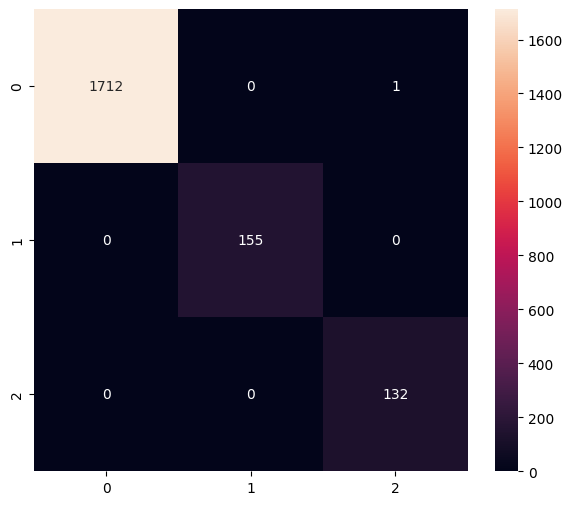

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1713
           1       1.00      1.00      1.00       155
           2       0.99      1.00      1.00       132

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_m_test, y_pred))

Y_pred = m_model.predict(X_m_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_m_test, y_pred)

## Accuracy and Loss

In [13]:
val_loss, val_acc = m_model.evaluate(X_m_test, y_m_test, batch_size=BATCH_SIZE)

250/250 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.9995


## Predict Unseen Data

In [14]:
predict_result = m_model.predict(np.array([X_m_test[0]]))
print(predict_result)
print(np.squeeze(predict_result))
print(np.sum((predict_result)))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 14ms/step
[[1.0000000e+00 2.3511307e-23 1.3699440e-15]]
[1.0000000e+00 2.3511307e-23 1.3699440e-15]
1.0
0


# Convert TFLite

## Save Model

In [15]:
m_model.save(m_model_save_path)

## Load Model

In [16]:
m_model = tf.keras.models.load_model(m_model_save_path)

## Quantization & Save

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(m_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]
tflite_quantized_model = converter.convert()

open(m_tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\zhiweiy\AppData\Local\Temp\tmpbg6y5odf\assets


INFO:tensorflow:Assets written to: C:\Users\zhiweiy\AppData\Local\Temp\tmpbg6y5odf\assets


347296

# Inference test

## Setup Interpreter Interface

In [18]:
interpreter = tf.lite.Interpreter(model_path=m_tflite_save_path)
interpreter.allocate_tensors()

## Get Tensor Details

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

## Implement Inference

### Setup Input Tensor

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_m_test[0]]))

### Invoke Interpreter

In [21]:
%%time
interpreter.invoke()

CPU times: total: 0 ns
Wall time: 1.13 ms


### Get Tensor Output

In [22]:
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.0000000e+00 2.3511125e-23 1.3699439e-15]
0
